**Importing Data and Libraries**

In [34]:
pip install pulp

In [35]:
#Import Pulp Libraries
import pandas as pd
from pulp import *
import numpy as np
np.random.seed(0)

In [36]:
#Import Libraries for Triangle Distribution
import matplotlib.pyplot as plt
import time
from scipy import stats as stats
from scipy.stats import norm as norm
from scipy.stats import triang as triang
from scipy.stats import beta as beta
from scipy.stats import rv_continuous
import scipy.optimize as opt

In [37]:
#Upload the Files from Computer
from google.colab import files
uploaded = files.upload()

Saving input_capacity.csv to input_capacity (1).csv
Saving input_demand.csv to input_demand (1).csv
Saving input_financials.csv to input_financials (1).csv
Saving input_utilization.csv to input_utilization (1).csv


**Transforming Data**

*Remove Facility One and Outpatient data from Data Frames*

In [49]:
# Edit Capacity Data Frame
df_capacity = pd.read_csv('input_capacity.csv', index_col = False)
#Remove Facility One data from the Frame
df_capacity = df_capacity.loc[df_capacity["facility"] != "facility1"]
df_capacity.head(5)

,facility,service_line,sub_service,resource,Capacity
0,ALL,ALL,ALL,Ventilators,25
5,facility2,ALL,ALL,Bariatric Beds,2
6,facility2,ALL,ALL,Cardiac Short Stay Beds,8
7,facility2,ALL,ALL,Cardiac Transplant Beds,8
8,facility2,ALL,ALL,Cardiac VIP Beds,8


In [50]:
# Edit Financials Data Frame
df_rev = pd.read_csv('input_financials.csv', index_col = False)
#Remove Facility One and Outpatient data from the Frame
df_rev = df_rev.loc[df_rev["facility"] != "facility1"]
df_rev = df_rev.loc[df_rev["ip_op_indicator"] != "O"]
#Sort Values by Sub-Service
df_rev= df_rev.sort_values(by= ['sub_service'])
df_rev.head(5)


,facility,service_line,sub_service,ip_op_indicator,med_surg_indicator,revenue,margin
17,facility2,Cardiac Services,Cardiac Cath,I,SURG,32173.57,9791.10
18,facility2,Cardiac Services,Cardiac EP,I,SURG,55859.77,25878.12
19,facility2,Cardiac Services,Cardiac Surgery,I,SURG,123335.32,64148.76
26,facility2,Gynecology,General Surgical Gynecology,I,SURG,18376.49,10111.27
27,facility2,Gynecology,Gyn Surgical Oncology,I,SURG,26827.67,12451.33


In [51]:
# Edit Utilization Data Frame
df_utilize = pd.read_csv('input_utilization.csv', index_col = False)
#Remove Facility One and Outpatient data from the Frame
df_utilize = df_utilize.loc[df_utilize["facility"] != "facility1"]
df_utilize = df_utilize.loc[df_utilize["ip_op_indicator"] != "O"]
#Drop all columns with only null Values
df_utilize = df_utilize.dropna(axis=1)
df_utilize.head(5)

,facility,service_line,sub_service,ip_op_indicator,med_surg_indicator,resource,utilization_mean
35,facility2,Cardiac Services,Cardiac Cath,I,SURG,Cardiac Short Stay Beds,0.135
36,facility2,Cardiac Services,Cardiac Cath,I,SURG,Cardiac Transplant Beds,0.012
37,facility2,Cardiac Services,Cardiac Cath,I,SURG,Cardiac VIP Beds,0.012
38,facility2,Cardiac Services,Cardiac Cath,I,SURG,Cardiology Stepdown Beds,0.466
39,facility2,Cardiac Services,Cardiac Cath,I,SURG,Cardiovascular Surgery ICU Beds,0.017


In [52]:
# Edit Demand Data Frame
df_demand = pd.read_csv('input_demand.csv', index_col = False)
#Remove Facility One and Outpatient data from the Frame
df_demand = df_demand.loc[df_demand["facility"] != "facility1"]
df_demand = df_demand.loc[df_demand["ip_op_indicator"] != "O"]
df_demand.head(5)

,facility,service_line,sub_service,ip_op_indicator,med_surg_indicator,demand,date
3441,facility2,Cardiac Services,Cardiac Cath,I,SURG,4,3/1/2018
3442,facility2,Cardiac Services,Cardiac Cath,I,SURG,7,3/2/2018
3443,facility2,Cardiac Services,Cardiac Cath,I,SURG,2,3/3/2018
3444,facility2,Cardiac Services,Cardiac Cath,I,SURG,3,3/4/2018
3445,facility2,Cardiac Services,Cardiac Cath,I,SURG,2,3/5/2018


*Transform Utilization and Demand Data Frames*

In [53]:
#Sumarizing Resource Utlization- The Number of Resources Required by Each Sub-Service per Day
#Drop Facility, Service Line, Ip_OP, and Med_Surg Columns
df_utilize_sum= df_utilize.drop(['facility', 'service_line', 'ip_op_indicator', 'med_surg_indicator'], axis=1)
#Pivot Utilization Data Frame by Sub-Service
df_utilize_sum = df_utilize_sum.pivot(index='sub_service', columns='resource', values='utilization_mean')
df_utilize_sum= df_utilize_sum.reset_index()
#Fill in Resource Null Values with 0
df_utilize_sum= df_utilize_sum.fillna(0)
df_utilize_sum.head(5)


resource,sub_service,Bariatric Beds,Cardiac Short Stay Beds,Cardiac Transplant Beds,Cardiac VIP Beds,Cardiology Stepdown Beds,Cardiovascular Surgery ICU Beds,Cardiovascular Surgery Stepdown Beds,Colorectal Surgery Beds,Coronary ICU Beds,...,Pediatric Intermediate Care Beds,Short Stay Beds,Surgery ICU Beds,Surgical Telemetry Beds,Thoracic Surgery Stepdown Beds,Transplant Beds,Urology Beds,Vascular Surgery ICU Beds,Vascular Surgery Stepdown Beds,Ventilators
0,Cardiac Cath,0.000,0.135,0.012,0.012,0.466,0.017,0.111,0.000,0.088,...,0.000,0.000,0.001,0.000,0.019,0.002,0.001,0.001,0.018,0.024
1,Cardiac EP,0.000,0.001,0.011,0.037,0.290,0.026,0.288,0.000,0.103,...,0.000,0.000,0.002,0.001,0.045,0.002,0.005,0.003,0.050,0.030
2,Cardiac Surgery,0.000,0.003,0.013,0.008,0.082,0.249,0.456,0.001,0.029,...,0.000,0.000,0.000,0.000,0.013,0.000,0.000,0.025,0.018,0.147
3,General Surgical Gynecology,0.003,0.000,0.000,0.005,0.000,0.002,0.013,0.068,0.000,...,0.014,0.006,0.044,0.024,0.000,0.003,0.045,0.000,0.000,0.024
4,Gyn Surgical Oncology,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.011,0.000,...,0.000,0.001,0.048,0.033,0.000,0.000,0.021,0.000,0.000,0.033


*Calculate Total Average Daily Demand*

In [54]:
#Count the number of unique values in each column of the Demand Data Frame
df_demand.nunique()

facility                1
service_line            2
sub_service             7
ip_op_indicator         1
med_surg_indicator      2
demand                 39
date                  731
dtype: int64

In [55]:
#Sumarizing Demand- The total number of services demanded by each Sub-Service
df_demand1= df_demand.groupby(by=['sub_service', 'med_surg_indicator']).sum('demand')
df_demand1= df_demand1.reset_index()
df_demand1.head(5)


,sub_service,med_surg_indicator,demand
0,Cardiac Cath,SURG,2681
1,Cardiac EP,SURG,993
2,Cardiac Surgery,SURG,8102
3,General Surgical Gynecology,SURG,338
4,Gyn Surgical Oncology,SURG,272


In [56]:
#Calculate the Total Average Demand by Subservice
df_demand1['demand'] = df_demand1['demand'].div(731).round()
df_demand1

,sub_service,med_surg_indicator,demand
0,Cardiac Cath,SURG,4.0
1,Cardiac EP,SURG,1.0
2,Cardiac Surgery,SURG,11.0
3,General Surgical Gynecology,SURG,0.0
4,Gyn Surgical Oncology,SURG,0.0
5,Medical Cardiology,MED,16.0
6,Medical Gynecology,MED,0.0


*Calculate the Triangle Distribution Average Daily Demand for each Sub-Service: Using Min, Max, and Mode*

*   Title: Python Scenario Analysis: Modeling Expert Estimates with the beta-PERT Distribution
*   Author: Heiko Onnen
*   Date: October 25, 2021
*   Available from: https://towardsdatascience.com/python-scenario-analysis-modeling-expert-estimates-with-the-beta-pert-distribution-22a5e90cfa79 

In [57]:
#Drop the Facility, Service Line, Ip_OP, and Med_Surg Columns
df_demand= df_demand.drop(columns= ['facility', 'service_line', 'ip_op_indicator', 'med_surg_indicator'])

In [58]:
#Transform the Demand Data Frame to list all unique dates for each Sub-Service
#Pivot Demand Data Frame by Date
df_demand['date'] = pd.to_datetime(df_demand['date'])
df_demand = df_demand.pivot(index='date', columns='sub_service', values='demand')
df_demand = df_demand.sort_values('date')
#Fill in Date Null Values with 0
df_demand= df_demand.fillna(0)
#Pivot Demand Data Frame back to Sub-Service
df_demand = df_demand.stack().reset_index().sort_values(by=['sub_service', 'date'], axis=0)
df_demand.reset_index()
df_demand.rename(columns = {0: 'demand'}, inplace=True)
df_demand = df_demand[['sub_service', 'date', 'demand']]
df_demand.tail(5)

,sub_service,date,demand
5088,Medical Gynecology,2020-02-25,0.0
5095,Medical Gynecology,2020-02-26,0.0
5102,Medical Gynecology,2020-02-27,0.0
5109,Medical Gynecology,2020-02-28,0.0
5116,Medical Gynecology,2020-02-29,1.0


5.0

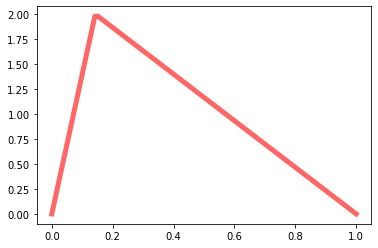

In [59]:
#Triangle Distribution for Cardiac Cath
#Calculate Cardiac Cath Mode, Min, and Max only
c_cath = df_demand[df_demand['sub_service']=='Cardiac Cath']
cath_m =c_cath.mode()['demand'][0]
cath_min =c_cath['demand'].min()
cath_max =c_cath['demand'].max()
#Scale Cardiac Cath Mode, Min, and Max and Plot on a Graph
cath_scale= (cath_m-cath_min)/(cath_max-cath_min)
cath_rvT =triang(cath_scale)
x = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, cath_rvT.pdf(x), 'r-', lw=5, alpha=0.6, label='Triangular pdf')
#Calculate Triangle Distribution Average Daily Demand for Cardiac Cath
cath_mean= cath_rvT.mean() *(cath_max-cath_min) + cath_min
cath_mean.round()

3.0

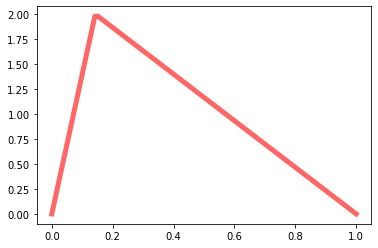

In [60]:
#Triangle Distribution for Cardiac EP
#Calculate Cardiac EP Mode, Min, and Max only
c_cep = df_demand[df_demand['sub_service']=='Cardiac EP']
cep_m =c_cep.mode()['demand'][0]
cep_min =c_cep['demand'].min()
cep_max =c_cep['demand'].max()
#Scale Cardiac EP Mode, Min, and Max and Plot on a Graph
cep_scale= (cep_m-cep_min)/(cep_max-cep_min)
cep_rvT =triang(cep_scale)
x = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, cep_rvT.pdf(x), 'r-', lw=5, alpha=0.6, label='Triangular pdf')
#Calculate Triangle Distribution Average Daily Demand for Cardiac Ep
cep_mean= cep_rvT.mean() *(cep_max-cep_min) + cep_min
cep_mean.round()

13.0

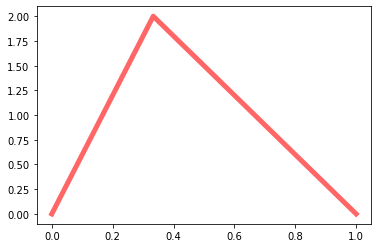

In [61]:
#Triangle Distribution for Cardiac Surgery
#Calculate Cardiac Surgery Mode, Min, and Max only
c_cs = df_demand[df_demand['sub_service']=='Cardiac Surgery']
cs_m =c_cs.mode()['demand'][0]
cs_min =c_cs['demand'].min()
cs_max =c_cs['demand'].max()
#Scale Cardiac Surgery Mode, Min, and Max and Plot on a Graph
cs_scale= (cs_m-cs_min)/(cs_max-cs_min)
cs_rvT =triang(cs_scale)
x = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, cs_rvT.pdf(x), 'r-', lw=5, alpha=0.6, label='Triangular pdf')
#Calculate Triangle Distribution Average Daily Demand for Cardiac Surgery
cs_mean= cs_rvT.mean() *(cs_max-cs_min) + cs_min
cs_mean.round()

1.0

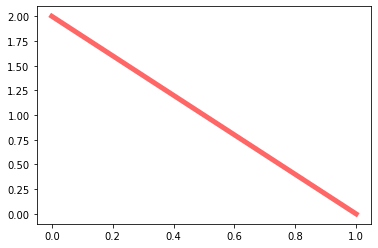

In [62]:
#Triangle Distribution for General Surgical Gynecology
#Calculate General Surgical Gynecology Mode, Min, and Max only
c_gsg = df_demand[df_demand['sub_service']=='General Surgical Gynecology']
gsg_m =c_gsg.mode()['demand'][0]
gsg_min =c_gsg['demand'].min()
gsg_max =c_gsg['demand'].max()
#Scale General Surgical Gynecology Mode, Min, and Max and Plot on a Graph
#min and mode are the same so it will be a "ramp shape"
gsg_scale= (gsg_m-gsg_min)/(gsg_max-gsg_min)
gsg_rvT =triang(gsg_scale)
x = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, gsg_rvT.pdf(x), 'r-', lw=5, alpha=0.6, label='Triangular pdf')
#Calculate Triangle Distribution Average Daily Demand for General Surgical Gynecology
gsg_mean= gsg_rvT.mean() *(gsg_max-gsg_min) + gsg_min
gsg_mean.round()

1.0

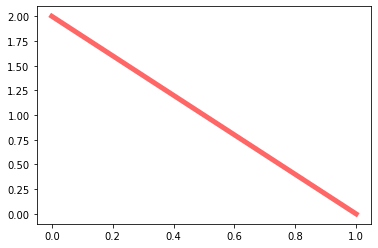

In [63]:
#Triangle Distribution for Gyn Surgical Oncology
#Calculate Gyn Surgical Oncology Mode, Min, and Max only
c_gso = df_demand[df_demand['sub_service']=='Gyn Surgical Oncology']
gso_m =c_gso.mode()['demand'][0]
gso_min =c_gso['demand'].min()
gso_max =c_gso['demand'].max()
#Scale Gyn Surgical Oncology Mode, Min, and Max and Plot on a Graph
#min and mode are the same so it will be a "ramp shape"
gso_scale= (gso_m-gso_min)/(gso_max-gso_min)
gso_rvT =triang(gso_scale)
x = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, gso_rvT.pdf(x), 'r-', lw=5, alpha=0.6, label='Triangular pdf')
#Calculate Triangle Distribution Average Daily Demand for Gyn Surgical Oncology
gso_mean= gso_rvT.mean() *(gso_max-gso_min) + gso_min
gso_mean.round()

19.0

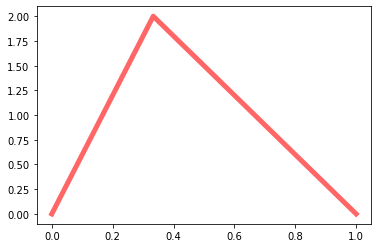

In [64]:
#Triangle Distribution for Medical Cardiology
#Calculate Medical Cardiology Mode, Min, and Max only
c_mc = df_demand[df_demand['sub_service']=='Medical Cardiology']
mc_m =c_mc.mode()['demand'][0]
mc_min =c_mc['demand'].min()
mc_max =c_mc['demand'].max()
#Scale Medical Cardiology Mode, Min, and Max and Plot on a Graph
mc_scale= (mc_m-mc_min)/(mc_max-mc_min)
mc_rvT =triang(mc_scale)
x = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, mc_rvT.pdf(x), 'r-', lw=5, alpha=0.6, label='Triangular pdf')
#Calculate Triangle Distribution Average Daily Demand for Medical Cardiology
mc_mean= mc_rvT.mean() *(mc_max-mc_min) + mc_min
mc_mean.round()

1.0

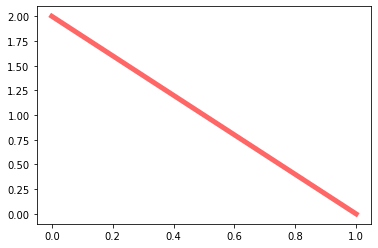

In [66]:
#Triangle Distribution for Medical Gynecology
#Calculate Medical Gynecology Mode, Min, and Max only
c_mg = df_demand[df_demand['sub_service']=='Medical Gynecology']
mg_m =c_mg.mode()['demand'][0]
mg_min =c_mg['demand'].min()
mg_max =c_mg['demand'].max()
#Scale Medical Gynecology Mode, Min, and Max and Plot on a Graph
#min and mode are the same so it will be a "ramp shape"
mg_scale= (mg_m-mg_min)/(mg_max-mg_min)
mg_rvT =triang(mg_scale)
x = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, mg_rvT.pdf(x), 'r-', lw=5, alpha=0.6, label='Triangular pdf')
#Calculate Triangle Distribution Average Daily Demand for Medical Gynecology
mg_mean= mg_rvT.mean() *(mg_max-mg_min) + mg_min
mg_mean.round()

**Define Decision Variables and Constraints**

*   Title: Optimization Python
*   Author: Tirthajyoti Sarkar
*   Date: 2020
*   Code Version: Python 3+
*   Available from: https://github.com/tirthajyoti/Optimization-Python/commit/708a3a61e6d0a7aabb3294a8b8b5d79edc816a4d








*Decision Variable- The Number of Sub-Services to offer each day*

In [67]:
#The Demand Data Frame will determine the available Sub-Services
dem_list= list(df_demand['sub_service'])
sub_serve= list(dict.fromkeys(dem_list))
sub_serve.sort()

#Define the Sub-Service Decision Variable
sub_vars= LpVariable.dicts('x',sub_serve, 0, cat="Integer")

Constraints- Margin, Demand, Resource Capacity, and Resource Utilization

In [68]:
#The Margin of each Sub-Service
margin= dict(zip(sub_serve, df_rev['margin']))
margin


{'Cardiac Cath': 9791.1,
 'Cardiac EP': 25878.12,
 'Cardiac Surgery': 64148.76,
 'General Surgical Gynecology': 10111.27,
 'Gyn Surgical Oncology': 12451.33,
 'Medical Cardiology': 3629.9,
 'Medical Gynecology': 1976.44}

In [69]:
#The Total Average Daily Demand of each Sub-Service
demand= dict(zip(sub_serve, df_demand1['demand']))
demand

{'Cardiac Cath': 4.0,
 'Cardiac EP': 1.0,
 'Cardiac Surgery': 11.0,
 'General Surgical Gynecology': 0.0,
 'Gyn Surgical Oncology': 0.0,
 'Medical Cardiology': 16.0,
 'Medical Gynecology': 0.0}

In [70]:
#The Resource Capacity for Facility 2
df_capacity[['resource', 'Capacity']].head(5)

,resource,Capacity
0,Ventilators,25
5,Bariatric Beds,2
6,Cardiac Short Stay Beds,8
7,Cardiac Transplant Beds,8
8,Cardiac VIP Beds,8


In [71]:
#The Average number of each resource required by each Sub-service
cass_bed = dict(zip(sub_serve,df_utilize_sum['Cardiac Short Stay Beds']))
cat_bed = dict(zip(sub_serve,df_utilize_sum['Cardiac Transplant Beds']))
cav_bed = dict(zip(sub_serve,df_utilize_sum['Cardiac VIP Beds']))
cas_bed = dict(zip(sub_serve,df_utilize_sum['Cardiology Stepdown Beds']))
cvsi_bed = dict(zip(sub_serve,df_utilize_sum['Cardiovascular Surgery ICU Beds']))
cvss_bed = dict(zip(sub_serve,df_utilize_sum['Cardiovascular Surgery Stepdown Beds']))
cos_bed = dict(zip(sub_serve,df_utilize_sum['Colorectal Surgery Beds']))
cori_bed = dict(zip(sub_serve,df_utilize_sum['Coronary ICU Beds']))
edo_bed = dict(zip(sub_serve,df_utilize_sum['ED Observation Beds']))
hfi_bed = dict(zip(sub_serve,df_utilize_sum['Heart Failure ICU Beds']))
mi_bed = dict(zip(sub_serve,df_utilize_sum['Medical ICU Beds']))
medi_bed = dict(zip(sub_serve,df_utilize_sum['Medicine Beds']))
ni_bed = dict(zip(sub_serve,df_utilize_sum['Neuro ICU Beds']))
nmed_bed = dict(zip(sub_serve,df_utilize_sum['Neuro MedSurg Beds']))
op_rm = dict(zip(sub_serve,df_utilize_sum['Operating Rooms']))
orth_bed = dict(zip(sub_serve,df_utilize_sum['Ortho Beds']))
ped_bed = dict(zip(sub_serve,df_utilize_sum['Pediatric Intensive Care Unit Beds']))
si_bed = dict(zip(sub_serve,df_utilize_sum['Surgery ICU Beds']))
tss_bed = dict(zip(sub_serve,df_utilize_sum['Thoracic Surgery Stepdown Beds']))
tr_bed = dict(zip(sub_serve,df_utilize_sum['Transplant Beds']))
u_bed = dict(zip(sub_serve,df_utilize_sum['Urology Beds']))
vsi_bed = dict(zip(sub_serve,df_utilize_sum['Vascular Surgery ICU Beds']))
vss_bed = dict(zip(sub_serve,df_utilize_sum['Vascular Surgery Stepdown Beds']))
ven = dict(zip(sub_serve,df_utilize_sum['Ventilators']))
hc_bed = dict(zip(sub_serve,df_utilize_sum['Hemonc/Cancer Beds']))
st_bed = dict(zip(sub_serve,df_utilize_sum['Surgical Telemetry Beds']))
nni_bed = dict(zip(sub_serve,df_utilize_sum['Neonatal ICU Beds']))
pedi_bed = dict(zip(sub_serve,df_utilize_sum['Pediatric Intermediate Care Beds']))
ba_bed = dict(zip(sub_serve,df_utilize_sum['Bariatric Beds']))
ob_bed = dict(zip(sub_serve,df_utilize_sum['OBGYN Beds']))
ss_bed = dict(zip(sub_serve,df_utilize_sum['Short Stay Beds']))
#The average number of ss_bed required by each Sub-service
ss_bed

{'Cardiac Cath': 0.0,
 'Cardiac EP': 0.0,
 'Cardiac Surgery': 0.0,
 'General Surgical Gynecology': 0.006,
 'Gyn Surgical Oncology': 0.001,
 'Medical Cardiology': 0.0,
 'Medical Gynecology': 0.0}

**Build the Optimization Model**

*   Title: Optimization Python
*   Author: Tirthajyoti Sarkar
*   Date: 2020
*   Code Version: Python 3+
*   Available from: https://github.com/tirthajyoti/Optimization-Python/commit/708a3a61e6d0a7aabb3294a8b8b5d79edc816a4d








In [79]:
#Maximize the Total Profit (Margin) for the Sum of all Sub Services
prob= LpProblem("Sub-Service", LpMaximize)
prob += lpSum([margin[i]*sub_vars [i] for i in sub_serve])

In [80]:
#Adding Facility 2 Resource Capacity Constraints
prob += lpSum([cass_bed[f] * sub_vars[f] for f in sub_serve]) <= 8
prob += lpSum([cat_bed[f] * sub_vars[f] for f in sub_serve]) <= 8
prob += lpSum([cav_bed[f] * sub_vars[f] for f in sub_serve]) <= 8
prob += lpSum([cas_bed[f] * sub_vars[f] for f in sub_serve]) <= 14
prob += lpSum([cvsi_bed[f] * sub_vars[f] for f in sub_serve]) <= 19
prob += lpSum([cvss_bed[f] * sub_vars[f] for f in sub_serve]) <= 20
prob += lpSum([cos_bed[f] * sub_vars[f] for f in sub_serve]) <= 8
prob += lpSum([cori_bed[f] * sub_vars[f] for f in sub_serve]) <= 6
prob += lpSum([edo_bed[f] * sub_vars[f] for f in sub_serve]) <= 3
prob += lpSum([hfi_bed[f] * sub_vars[f] for f in sub_serve]) <= 2
prob += lpSum([mi_bed[f] * sub_vars[f] for f in sub_serve]) <= 8
prob += lpSum([medi_bed[f] * sub_vars[f] for f in sub_serve]) <= 12
prob += lpSum([ni_bed[f] * sub_vars[f] for f in sub_serve]) <= 6
prob += lpSum([nmed_bed[f] * sub_vars[f] for f in sub_serve]) <= 22
prob += lpSum([op_rm[f] * sub_vars[f] for f in sub_serve]) <= 48
prob += lpSum([orth_bed[f] * sub_vars[f] for f in sub_serve]) <= 7
prob += lpSum([ped_bed[f] * sub_vars[f] for f in sub_serve]) <= 6
prob += lpSum([si_bed[f] * sub_vars[f] for f in sub_serve]) <= 5
prob += lpSum([tss_bed[f] * sub_vars[f] for f in sub_serve]) <= 5
prob += lpSum([tr_bed[f] * sub_vars[f] for f in sub_serve]) <= 6
prob += lpSum([u_bed[f] * sub_vars[f] for f in sub_serve]) <= 8
prob += lpSum([vsi_bed[f] * sub_vars[f] for f in sub_serve]) <= 3
prob += lpSum([vss_bed[f] * sub_vars[f] for f in sub_serve]) <= 6
prob += lpSum([ven[f] * sub_vars[f] for f in sub_serve]) <= 25
prob += lpSum([hc_bed[f] * sub_vars[f] for f in sub_serve]) <= 8
prob += lpSum([st_bed[f] * sub_vars[f] for f in sub_serve]) <= 7
prob += lpSum([nni_bed[f] * sub_vars[f] for f in sub_serve]) <= 4
prob += lpSum([pedi_bed[f] * sub_vars[f] for f in sub_serve]) <= 3
prob += lpSum([ba_bed[f] * sub_vars[f] for f in sub_serve]) <= 2
prob += lpSum([ob_bed[f] * sub_vars[f] for f in sub_serve]) <= 3
prob += lpSum([ss_bed[f] * sub_vars[f] for f in sub_serve]) <= 5

In [81]:
#Adding the Triangle Distribution Average Daily Demand Constraint for each Sub-Service

prob += sub_vars['Cardiac Cath'] >= 5
prob += sub_vars['Cardiac EP'] >=  3
prob += sub_vars['Cardiac Surgery'] >= 13
prob += sub_vars['General Surgical Gynecology'] >= 1
prob += sub_vars['Gyn Surgical Oncology'] >= 1
prob += sub_vars['Medical Cardiology'] >= 19
prob += sub_vars['Medical Gynecology'] >= 1


In [82]:
#Determining if the Model is Feasible
prob.solve()
print("Status:", LpStatus[prob.status])

Status: Optimal


In [83]:
#Determing the Objective Margin
print("Objective: z* = {}".format(
value(prob.objective)))


Objective: z* = 2310547.6500000004


In [84]:
#Determining the Ideal Number of Sub-Services to Offer
for v in prob.variables():
    if v.varValue>0:
        print(v.name, "=", v.varValue)


x_Cardiac_Cath = 6.0
x_Cardiac_EP = 3.0
x_Cardiac_Surgery = 32.0
x_General_Surgical_Gynecology = 2.0
x_Gyn_Surgical_Oncology = 1.0
x_Medical_Cardiology = 19.0
x_Medical_Gynecology = 10.0


### Results

In [85]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Original_Code.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Team_Japan_Original_Code.ipynb to pdf
[NbConvertApp] Support files will be in Team_Japan_Original_Code_files/
[NbConvertApp] Making directory ./Team_Japan_Original_Code_files
[NbConvertApp] Making directory ./Team_Japan_Original_Code_files
[NbConvertApp] Making directory ./Team_Japan_Original_Code_files
[NbConvertApp] Making directory ./Team_Japan_Original_Code_files
[NbConvertApp] Making directory ./Team_Japan_Original_Code_files
[NbConvertApp] Making directory ./Team_Japan_Original_Code_files
[NbConvertApp] Making directory ./Team_Japan_Original_Code_files
[NbConvertApp] Writing 95755 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'